# Analytic 1D Solution

Allow the following definitions/assumptions:

1. The sky is has a uniform distribution of point sources that follow a power-law source count spectrum. This distribution is uniform in (l,m) for simplicity.
2. Each antenna/tile has the same frequency-independent Gaussian beam.
3. Each antenna/tile has the same bandpass, whose multiplication with a frequency taper we will call $\phi$.
4. The frequency channels are fine enough* that it is a reasonable approximation to represent the visibility in each channel as the instantaneous value at the central frequency, rather than the average throughout the channel.
5. All baselines lie along a 1D slice.
6. Let $\nu_0$ be a reference frequency, and also the central frequency of the band (at which $\phi(\nu_0) = 1$).
7. Let $f = \nu/\nu_0$ be a normalised frequency.
8. Let $\omega = \nu_0 \eta$ be a unitless fourier-dual to frequency.
9. Let all _subscripted_ $u$ be defined as the value of $u$ for a _specific baseline_ at the reference frequency, so that the actual value of $u$ for baseline $i$ is $f u_i$.
10. Let the sampled frequencies be $f_k$, where $k \in (-n_f/2, n_f/2)$, and $f_0 = 1$.


*We'll probably have to think about what defines "fine enough" in this context later.

## One Baseline per Frequency Approximation

Slightly more controversially, let us consider the case in which the baselines are either completely redundant, or they are spaced widely enough that it is _almost always_ reasonable to approximate the value of the visibility at $u$ by the value of the floating visibility at the closest $u_i$. This imposes the limit that the average distance between baselines at this particular $u$ (and for the range of frequencies involved), is much larger than about $1/2\pi\sigma \approx 1$. If this is not the case, then the maths becomes significantly more difficult.

Then the expecation of the power spectrum is basically proportional to the variance of the visibility at $u, \omega$, which can be expressed as:

\begin{equation}
    {\rm Var}(V(u,\omega))  = \pi \sigma^2 \nu_0 \mu_2 \Delta_f^2 \sum_{j,k = -n_f/2}^{n_f/2} \phi_j\phi_k e^{-\pi^2\sigma^2 (f_j \hat{u}_j - f_k \hat{u}_k)^2} e^{-2\pi i \omega(f_j - f_k)},
\end{equation}

where $\hat{u}_j$ is defined as the value of $u_i$ for the baseline closest to $u$ at $f_j$. 

Some simple cases follow:

### Sparse Baselines

If baselines are _very widely_ spaced, such that $\hat{u}_{-n_f/2} = \hat{u}_{n_f/2} \approx u$, then we achieve

\begin{equation}
    {\rm Var}(V(u,\omega))  = \pi \sigma^2 \nu_0 \mu_2 \Delta_f^2 \sum_{j,k = -n_f/2}^{n_f/2} \phi_j\phi_k e^{-\pi^2\sigma^2 u^2 (f_j - f_k )^2} e^{-2\pi i \omega(f_j - f_k)}.
\end{equation}

which can be seen to be exactly analogous to the archetypical wedge case (see my wedge paper, Table 3).

### Total Redundancy

If baselines are spaced in any way such that the closest baseline is literally at $u$ for any frequency channel, then $f_j u_j \equiv u$, and the exponential term drops out, leaving a simple solution: ${\rm Var}(V) \propto \left|\hat{\phi}\right|^2(\omega)$. 

For this particular $u$, assuming that there exists a baseline at $u$ for $f_0$, then we require _at least_ the baselines $u_i = u/(1 + i \Delta_f)$ for $i \in (-n_f/2, n_f/2)$ for _this particular_ $u$. 

To evaluate a set of scales $u_\mu$ ($\mu < N_u$)  would thus require the set $\{u_\mu/(1 + i \Delta_f)\}$ which is no larger than $N_u n_f$, but may be smaller if suitable values of $u_\mu$ can be chosen so that baselines can coincide.

Problematically, given a standard observation setup of ~1000 channels over 100MHz, so that $\Delta_f \approx 0.1/150 = 6\times10^{-4}$, the relevant $u_i$ for say $u=50$, are spaced by $\Delta_u \approx 0.033$. Note that this is not a _precision_ of placement, but the necessary _density_ of baselines.

Possibly more problematically, at this density, the assumption that only the closest baseline counts is broken, and the entire equation doesn't hold any more. It is unclear to me at this point what the ramifications for this on the wedge are. The finest frequency channels allowable in order to maintain the assumption for the largest scales of interest ($u \sim 150$), are of the order of $\Delta_f = 1/150 = 6 \times 10^{-3}$, which correspond to 1MHz. But this limits the window to smaller $\omega$

### Partial Redundancy

What would happen if every $n^{th}$ frequency was completely redundant (at least, every $n^{th}$ had a baseline at $u$, and there were no other baselines in-between)? Then for the previous $n/2$ frequencies, and following $n/2$, the $\hat{u}_j$ would be the same

### Numerical Evaluation

In [1]:
import numpy as np
from powerbox.dft import fftfreq, fft
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
import pickle
import ctypes

from plot_tools import suplabel, make_plot

cdll = ctypes.CDLL("./varvis.so")

%matplotlib notebook

%load_ext autoreload
%autoreload 2

/home/steven/miniconda3/envs/pssim/lib/python3.6/site-packages/powerbox/dft.py:51: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


In [2]:
def get_f_omega(numin, numax, nf, nomega=50, log_omega=False):
    nu0 = (numin + numax) / 2
    f = np.linspace(numin / nu0, numax / nu0, nf)
    
    omega = fftfreq(len(f), d=f[1] - f[0], b=2 * np.pi)
    omega = omega[omega > 0]
    if log_omega:
        omega = np.logspace(np.log10(omega.min()), np.log10(omega.max()), nomega)
    
    return f, omega

In [4]:
# COMMON PARAMETERS
numin = 125
numax = 175
nf = 250

f, omega = get_f_omega(numin, numax, nf)

bl_nums = [100, 200, 300, 500]
u_points = [15, 50, 150]

bl_min = 3
bl_max = 250

taper = np.blackman
sigma = 0.2

log_omega = False

In [11]:
def var_vis_one_bl_per_freq(u, ui, f, omega, taper, sigma):
    """
    Evaluate the variance of visibility at u given baselines ui and frequencies f.
    
    Does so under the approximation that at any frequency, only the closest baseline
    to u actually contributes.
    """
    # Get closest baselines
    uj = np.zeros_like(f)
    for i,ff in enumerate(f):
        uj[i] = ff * ui[np.argmin(np.abs(u - ff*ui))]

    exp_part = np.exp(-np.pi**2*sigma**2*np.add.outer(uj,-uj)**2)

    bp = np.outer(taper(len(f)), taper(len(f)))
    bp *= exp_part
    omegaff = np.outer(omega, np.add.outer(f,-f)).reshape((len(omega), len(f), len(f)))
    
    kernel = np.exp(-2j*np.pi*omegaff)
    
    return np.abs(np.sum(kernel*bp, axis=(1,2)))
    
def var_vis_perfect_redundancy(f, omega, taper, sigma):
    """
    Determine the variance of visibilities in the limit of perfect redundancy, _and_
    that baselines are separated enough to allow the one_bl_per_freq approximation.
    """
    bp = np.outer(taper(len(f)), taper(len(f)))
    omegaff = np.outer(omega, np.add.outer(f,-f)).reshape((len(omega), len(f), len(f)))
    
    kernel = np.exp(-2j*np.pi*omegaff)
    
    return np.abs(np.sum(kernel*bp, axis=(1,2)))

## Denser Baselines

In the event that we can pack baselines closer than $\Delta \approx 1$ (and we'll need to do this to eliminate the wedge), then the approximation above will not work. **That is, we should pretty much just completely ignore the above.**

In this case we begin from the following:

\begin{align}
		{\rm Var}(\tilde{V}) &= \mu_2\nu_0^2 \int d^2\vec{l}\  e^{-l^2/\sigma^2} |I|^2, \\
		I &= \Delta_f \sum_{j=-nf/2}^{n_f/2}\ \frac{\phi_\nu}{W_\nu(\vec{u})}  \sum_{i=1}^{N_{\rm bl}} B(\vec{u} - f\vec{u}_i)e^{-2\pi i f(\omega + \vec{l}\cdot\vec{u}_i)} \nonumber \\
		&= \Delta_f \sum_{j=-nf/2}^{n_f/2}\frac{\phi_\nu \sum_{i=1}^{N_{\rm bl}} e^{-2\pi^2\sigma^2(\vec{u}-f\vec{u}_i)^2} e^{-2\pi i f(\omega + \vec{l}\cdot\vec{u}_i)}}{\sum_{i=1}^{N_{\rm bl}} e^{-2\pi^2\sigma^2(\vec{u}-f\vec{u}_i)^2}} \\
        W_\nu(u) &= \sum_{i=1}^{N_{\rm bl}} e^{-2\pi^2\sigma^2(\vec{u}-f\vec{u}_i)^2} 
\end{align}


Doing the $l$ integral, we assume that all $u$ lie along the $x$-axis, which gives

\begin{align}
{\rm Var}(\tilde{V}) &= \sqrt{\pi \sigma^2} \mu_2\nu_0^2 \Delta^2_f
		\sum_{j,k=-n_f/2}^{n_f/2}  \frac{\phi_j\phi_k e^{-2\pi i \omega (f_j-f_k)}}{W_j(u)W_k(u)}\sum_{i,m=1}^{N_{\rm bl}} e^{-2\pi^2\sigma^2(\vec{u}-f_ju_i)^2} e^{-2\pi^2\sigma^2(u-f_ku_m)^2} \int d l_y\  e^{-l_y^2/\sigma^2} e^{-2\pi i l_y( f_j u_i - f_ku_m)}  \\
        &= \pi \sigma^2 \mu_2\nu_0^2 \Delta^2_f
		\sum_{j,k=-n_f/2}^{n_f/2}  \frac{\phi_j\phi_k e^{-2\pi i \omega (f_j-f_k)}}{W_j(u)W_k(u)}\sum_{i,m=1}^{N_{\rm bl}} e^{-2\pi^2\sigma^2(u-f_ju_i)^2} e^{-2\pi^2\sigma^2(u-f_ku_m)^2}  e^{-\pi^2\sigma^2 ( f_j u_i - f_ku_m)^2}.
\end{align}

Note that this reduces to the single-baseline-per-frequency case when we assume that it applies.

### Numerical Evaluation

In [9]:
def var_vis_general(u, ui, f, omega, taper, sigma, extent=5, nthreads=None):    
    """
    Evaluate the variance of a visibility at u given baselines ui and frequencies f. 
    
    All baselines are used in the weighted average, as long as they are with `extent` by the kernel width.
    """
    if not nthreads:
        nthreads = cpu_count()

    cdll.var_vis.restype = ctypes.c_int
    cdll.var_vis.argtypes = [
        ctypes.c_int, ctypes.c_int, ctypes.c_int,
        np.ctypeslib.ndpointer(np.float64), np.ctypeslib.ndpointer(np.float64), np.ctypeslib.ndpointer(np.float64),
        np.ctypeslib.ndpointer(np.float64), ctypes.c_double, ctypes.c_double, ctypes.c_double,
        np.ctypeslib.ndpointer(np.float64), ctypes.c_int
    ]

    res = np.zeros(len(omega))
    taper = taper(len(f))

    cdll.var_vis(
        len(f), len(omega), len(ui),
        np.ascontiguousarray(f), np.ascontiguousarray(omega), np.ascontiguousarray(ui),
        np.ascontiguousarray(taper), sigma, u, extent, res, nthreads)

    return res

In [78]:
# Actually perform calculations
expected_power = {}

# Get perfectly redundant solution
expected_power['omega'] = omega
expected_power['perfect'] = var_vis_perfect_redundancy(f, omega, taper, sigma)

for kind in ['lin', 'log']:
    expected_power[kind] = {}
    
    for i,n in enumerate(bl_nums):
        if kind=='log':
            ui = np.logspace(np.log10(bl_min), np.log10(bl_max), n)
        else:
            ui = np.linspace(bl_min, bl_max, n)
            
        for uu in u_points:
            print(f"Doing n={n}, u={uu}, {kind}")
            expected_power[kind][f'n={n} u={uu}'] = var_vis_general(uu, ui, f, omega, taper, sigma)

            # Dump results after every iter so we don't lose them.
            with open("expected_power.pkl", 'wb') as f:
                pickle.dump(expected_power, f)            

Doing n=100, u=15, lin
Doing n=100, u=50, lin
Doing n=100, u=150, lin
Doing n=200, u=15, lin
Doing n=200, u=50, lin
Doing n=200, u=150, lin
Doing n=300, u=15, lin
Doing n=300, u=50, lin
Doing n=300, u=150, lin
Doing n=500, u=15, lin
Doing n=500, u=50, lin
Doing n=500, u=150, lin
Doing n=100, u=15, log
Doing n=100, u=50, log
Doing n=100, u=150, log
Doing n=200, u=15, log
Doing n=200, u=50, log
Doing n=200, u=150, log
Doing n=300, u=15, log
Doing n=300, u=50, log
Doing n=300, u=150, log
Doing n=500, u=15, log
Doing n=500, u=50, log
Doing n=500, u=150, log


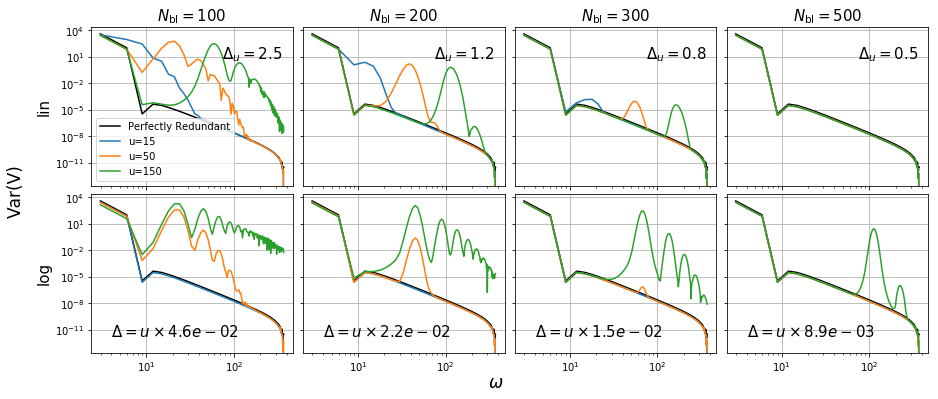

In [79]:
make_plot(expected_power)

### Plots of weights

In [83]:
def get_weight_at_u(u, sigma, ui):
    weight_i = np.exp(-2*np.pi**2*sigma**2*np.add.outer(u,-ui)**2)
    return np.sum(weight_i, axis=1)

def get_weights_f(u, ui, numin, numax, nf, sigma):
    # u, ui and f are arrays
    
    f = get_f_omega(numin, numax, nf)[0]
    
    wuf = np.zeros((len(u), len(f)))
    for i, ff in enumerate(f):
        wuf[:,i] = get_weight_at_u(u, sigma, ff*ui) 
        
    return f, wuf

def get_weights_om(wuf, f, taper):
    wuom, omega = fft(wuf * taper(len(f)), L=f[-1] - f[0], axes=(1,))
    
    omega = omega[0]
    wuom = wuom[:, omega>0]
    omega = omega[omega>0]
    
    return omega, np.abs(wuom)**2

In [62]:
# Create all weights
weights_f = {}
weights_om = {}

weights_om['perfect'] = var_vis_one_bl_per_freq(15, None, numin, numax, nf, taper, sigma)[1]

for kind in ['lin', 'log']:
    weights_f[kind] = {}
    weights_om[kind] = {}
    
    for i,n in enumerate(bl_nums):
        if kind=='log':
            ui = np.logspace(np.log10(bl_min), np.log10(bl_max), n)
        else:
            ui = np.linspace(bl_min, bl_max, n)
            
        f, wuf = get_weights_f(np.array(u_points), ui, numin, numax, nf, sigma)
        omega, wuom = get_weights_om(wuf, f, taper)
          
        if "omega" not in weights_f:
            weights_f['omega'] = omega
            weights_f['f'] = f
            weights_om['omega'] = omega
            weights_om['f'] = f
            
        for iu, uu in enumerate(u_points):
            weights_f[kind][f'n={n} u={uu}'] = wuf[iu]
            weights_om[kind][f'n={n} u={uu}'] = wuom[iu]
            
        

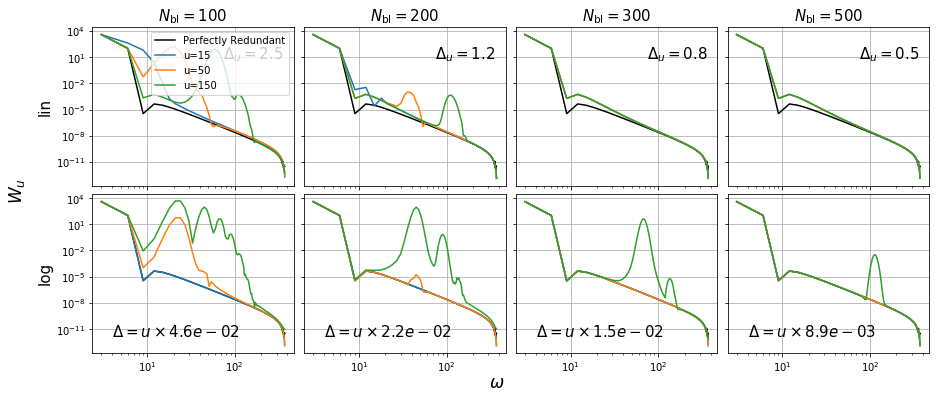

In [76]:
make_plot(weights_om, normalise_at=0, supy=r"$W_u$")

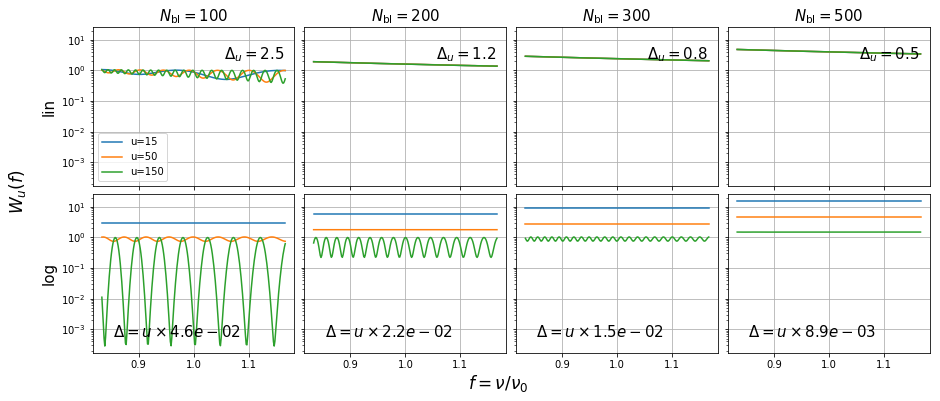

In [77]:
make_plot(weights_f, xscale_log=False, xquant='f', plot_perfect=False, supx=r"$f = \nu/\nu_0$", supy=r"$W_u(f)$")